# In this notebook, we shall explore the 3 objective functions of Learning To Rank namely :
    - Pointwise Approach
    - Pairwise Approach
    - Listwise Approach
    
# Also we will explore the following libraries :
    - Optuna for Hyper-parameter tuning
    - ranx for metric evaluation
    - SHAPLEY for feature importance

## Importing Libraries

In [26]:
import pandas as pd
import numpy as np
import shap
from ranx import Qrels, Run, evaluate, compare
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import train_test_split
from mord import LogisticAT
import xgboost as xgb
import optuna
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# Loading data

In [3]:
data = pd.read_csv('Hospital General Information.csv', sep=",", encoding='cp1252')

# Filtering only required columns

In [4]:
data = data[['Provider ID', 'Hospital Name', 'State', 'Hospital Type', 'Hospital Ownership',
       'Emergency Services', 'Meets criteria for meaningful use of EHRs',
       'Hospital overall rating', 
       'Mortality national comparison',
       'Safety of care national comparison',
       'Readmission national comparison',
       'Patient experience national comparison',
       'Effectiveness of care national comparison',
       'Timeliness of care national comparison',
       'Efficient use of medical imaging national comparison']]

In [5]:
data.head()

Provider ID                     Hospital Name State         Hospital Type  \
0        10001  SOUTHEAST ALABAMA MEDICAL CENTER    AL  Acute Care Hospitals   
1        10005     MARSHALL MEDICAL CENTER SOUTH    AL  Acute Care Hospitals   
2        10006    ELIZA COFFEE MEMORIAL HOSPITAL    AL  Acute Care Hospitals   
3        10007          MIZELL MEMORIAL HOSPITAL    AL  Acute Care Hospitals   
4        10008       CRENSHAW COMMUNITY HOSPITAL    AL  Acute Care Hospitals   

                            Hospital Ownership Emergency Services  \
0  Government - Hospital District or Authority                Yes   
1  Government - Hospital District or Authority                Yes   
2  Government - Hospital District or Authority                Yes   
3               Voluntary non-profit - Private                Yes   
4                                  Proprietary                Yes   

  Meets criteria for meaningful use of EHRs Hospital overall rating  \
0                                         Y                       3   
1                                         Y                       3   
2                                         Y                       2   
3                                         Y                       2   
4                                         Y                       3   

  Mortality national comparison Safety of care national comparison  \
0  Same as the national average         Above the national average   
1    Below the national average       Same as the national average   
2    Below the national average       Same as the national average   
3  Same as the national average                      Not Available   
4  Same as the national average                      Not Available   

  Readmission national comparison Patient experience national comparison  \
0    Same as the national average             Below the national average   
1      Above the national average           Same as the national average   
2    Same as the national average             Below the national average   
3      Below the national average           Same as the national average   
4    Same as the national average                          Not Available   

  Effectiveness of care national comparison  \
0              Same as the national average   
1              Same as the national average   
2              Same as the national average   
3                Below the national average   
4              Same as the national average   

  Timeliness of care national comparison  \
0           Same as the national average   
1             Above the national average   
2             Above the national average   
3             Above the national average   
4             Above the national average   

  Efficient use of medical imaging national comparison  
0                       Same as the national average    
1                         Below the national average    
2                       Same as the national average    
3                                      Not Available    
4                                      Not Available

In [6]:
data.shape

(4812, 15)

# Checking unique column values

In [7]:
print(data.apply(lambda col: col.unique()))

Provider ID                                             [10001, 10005, 10006, 10007, 10008, 10011, 100...
Hospital Name                                           [SOUTHEAST ALABAMA MEDICAL CENTER, MARSHALL ME...
State                                                   [AL, AK, AZ, AR, CA, CO, CT, DE, DC, FL, GA, H...
Hospital Type                                           [Acute Care Hospitals, Critical Access Hospita...
Hospital Ownership                                      [Government - Hospital District or Authority, ...
Emergency Services                                                                              [Yes, No]
Meets criteria for meaningful use of EHRs                                         [Y, nan, Not Available]
Hospital overall rating                                                    [3, 2, Not Available, 4, 5, 1]
Mortality national comparison                           [Same as the national average, Below the natio...
Safety of care national comparison            

# Dropping null values

In [8]:
data = data.dropna()

In [9]:
data.shape

(4669, 15)

# Checking the number of queries 

In [10]:
print(len(pd.unique(data['State'])))

56


# Replacing 'Not Available' with '0' and converting datatype to Integer

In [11]:
data['Hospital overall rating'] = data['Hospital overall rating'].replace(["Not Available"],0)

In [12]:
data['Hospital overall rating'] = data['Hospital overall rating'].astype(object).astype(int)

# Generating dummy variables for categorical variables

In [13]:
data_dummies = pd.get_dummies(data, columns = ['Hospital Name', 'Hospital Type', 'Hospital Ownership','Emergency Services',
                                               'Meets criteria for meaningful use of EHRs','Mortality national comparison',
                                               'Safety of care national comparison','Readmission national comparison',
                                               'Readmission national comparison','Patient experience national comparison',
                                               'Effectiveness of care national comparison',
                                               'Timeliness of care national comparison',
                                               'Efficient use of medical imaging national comparison'], drop_first = True)

In [14]:
data_dummies.shape

(4669, 4526)

## Pointwise Method

In [28]:
X = data_dummies.loc[:, ~data_dummies.columns.isin(['State','Hospital overall rating'])]
y = data_dummies.loc[:, data_dummies.columns.isin(['Hospital overall rating'])]

In [29]:
#assigning input and target values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, stratify=y, random_state=42)
X_train = X_train.loc[:, ~X_train.columns.isin(['State','Hospital overall rating'])]
X_test = X_test.loc[:, ~X_test.columns.isin(['State','Hospital overall rating'])]
Y = y_train['Hospital overall rating']

In [34]:
#creating the multinomial logistic regression model
regressor = LogisticAT(alpha=1.0, verbose=0)
regressor.fit(X_train, Y)

LogisticAT()

In [36]:
predictions_pointwise = regressor.predict(X_test)

In [33]:
predictions_pointwise

array([0, 4, 4, ..., 2, 4, 0])

# Groupwise Splitting on 'State' and Generating Train and Test data

In [14]:
gss = GroupShuffleSplit(test_size=.40, n_splits=1, random_state = 7).split(data_dummies, groups=data_dummies['State'])

X_train_inds, X_test_inds = next(gss)

In [15]:
train_data= data_dummies.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['State','Hospital overall rating'])]
y_train = train_data.loc[:, train_data.columns.isin(['Hospital overall rating'])]

In [16]:
test_data= data_dummies.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['Hospital overall rating'])]
y_test = test_data.loc[:, test_data.columns.isin(['Hospital overall rating'])]

In [17]:
groups = train_data.groupby('State').size().to_frame('size')['size'].to_numpy()

In [18]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]

In [19]:
X_test = X_test.loc[:,~X_test.columns.duplicated()]

# Defining Helper Functions

In [20]:
def predict(model, df):
    return model.predict(df.loc[:, ~df.columns.isin(['State'])])

In [21]:
def merge_df(X_test,predictions):
    X_test['pred_rank'] = 0.0
    counter = 0
    for i in range(0,len(X_test.index)):
        i = (i-i) + counter
        if(i>=len(X_test.index)):
            return X_test

        temp_state = X_test.State[i]
        for j in range(0,len(predictions)):
            if(temp_state == predictions.index[j]):
                for k in range(0,len(predictions[temp_state])):
                    X_test['pred_rank'][i] = predictions[temp_state][k]
                    i = i+1
                    counter = counter+1
    return X_test

In [22]:
def generate_qrels(Qrels_df,qrels_dict_final):
    counter = 0
    for i in range(0,len(Qrels_df.index)):
        qrels_dict = dict()
        i = (i-i) + counter
        if(i>=len(Qrels_df.index)):
            return qrels_dict_final

        temp_state = Qrels_df.State[i]
        for j in range(0,(Qrels_df.State == temp_state).sum()):
            qrels_dict[str(Qrels_df['Provider ID'][counter])] = Qrels_df['Hospital overall rating'][counter]
            counter = counter+1
        qrels_dict_final[temp_state] = qrels_dict
    return qrels_dict_final

In [23]:
def generate_run(run_df,run_dict_final):
    counter = 0
    for i in range(0,len(run_df.index)):
        run_dict = dict()
        i = (i-i) + counter
        if(i>=len(run_df.index)):
            return run_dict_final

        temp_state = run_df.State[i]
        for j in range(0,(run_df.State == temp_state).sum()):
            run_dict[str(run_df['Provider ID'][counter])] = run_df['pred_rank'][counter]
            counter = counter+1
        run_dict_final[temp_state] = run_dict
    return run_dict_final

In [24]:
def objective(trial,X_train=X_train,y_train=y_train,X_test=X_test,test_data=test_data,groups=groups):
    param = {
        'booster': 'gbtree',
        'objective': 'rank:pairwise',
        'random_state': 42,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.1,0.12,0.14,0.16,0.18, 0.2]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'eta': trial.suggest_categorical('eta', [0.04,0.05,0.06,0.07,0.08]),
        'max_depth': trial.suggest_categorical('max_depth', [5,6,7,9,11,13,15]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100,110,120,130,140,150]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.75,0.8,1.0]),
        'n_jobs': -1
    }
    
    model = xgb.XGBRanker(**param)
    model.fit(X_train, y_train, group=groups, verbose=True)
    
    predictions = (X_test.groupby('State')
               .apply(lambda x: predict(model, x)))
    
    X_test = X_test.reset_index()
    test_data = test_data.reset_index()
    test_data = test_data.loc[:,~test_data.columns.duplicated()]
    X_test_final = merge_df(test_data,predictions)
    
    Qrels_df = X_test_final[['Provider ID','State','Hospital overall rating']]
    run_df = X_test_final[['Provider ID','State','pred_rank']]
    
    Qrels_df = Qrels_df.groupby('State').apply(lambda x: x.sort_values('Hospital overall rating',ascending=False))
    run_df = run_df.groupby('State').apply(lambda x: x.sort_values('pred_rank',ascending=False))
    
    qrels_dict_final = dict()
    run_dict_final = dict()
    
    qrels = Qrels(generate_qrels(Qrels_df,qrels_dict_final))
    run = Run(generate_run(run_df,run_dict_final))
    
    ndcg = evaluate(qrels, run, "ndcg@5")
    
    return ndcg

In [25]:
def objective_listwise(trial,X_train=X_train,y_train=y_train,X_test=X_test,test_data=test_data,groups=groups):
    param = {
        'booster': 'gbtree',
        'objective': 'rank:ndcg',
        'random_state': 42,
        'learning_rate': trial.suggest_categorical('learning_rate', [0.08,0.1,0.12,0.14,0.16,0.18, 0.2]),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'eta': trial.suggest_categorical('eta', [0.04,0.05,0.06,0.07,0.08]),
        'max_depth': trial.suggest_categorical('max_depth', [5,6,7,9,11,13,15]),
        'n_estimators': trial.suggest_categorical('n_estimators', [100,110,120,130,140,150]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.75,0.8,1.0]),
        'n_jobs': -1
    }
    
    model = xgb.XGBRanker(**param)
    model.fit(X_train, y_train, group=groups, verbose=True)
    
    predictions = (X_test.groupby('State')
               .apply(lambda x: predict(model, x)))
    
    X_test = X_test.reset_index()
    test_data = test_data.reset_index()
    test_data = test_data.loc[:,~test_data.columns.duplicated()]
    X_test_final = merge_df(test_data,predictions)
    
    Qrels_df = X_test_final[['Provider ID','State','Hospital overall rating']]
    run_df = X_test_final[['Provider ID','State','pred_rank']]
    
    Qrels_df = Qrels_df.groupby('State').apply(lambda x: x.sort_values('Hospital overall rating',ascending=False))
    run_df = run_df.groupby('State').apply(lambda x: x.sort_values('pred_rank',ascending=False))
    
    qrels_dict_final = dict()
    run_dict_final = dict()
    
    qrels = Qrels(generate_qrels(Qrels_df,qrels_dict_final))
    run = Run(generate_run(run_df,run_dict_final))
    
    ndcg = evaluate(qrels, run, "ndcg@5")
    
    return ndcg

# Creating Optuna Study and Running Pairwise Model

In [26]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2022-08-28 11:59:56,036] A new study created in memory with name: no-name-fa9c3a43-7513-402f-91b1-cec2449d14fb
[I 2022-08-28 12:01:08,732] Trial 0 finished with value: 0.8677475218374618 and parameters: {'learning_rate': 0.16, 'colsample_bytree': 0.8, 'eta': 0.05, 'max_depth': 7, 'n_estimators': 130, 'subsample': 0.6}. Best is trial 0 with value: 0.8677475218374618.
[I 2022-08-28 12:02:09,885] Trial 1 finished with value: 0.8439022989666516 and parameters: {'learning_rate': 0.1, 'colsample_bytree': 0.3, 'eta': 0.06, 'max_depth': 15, 'n_estimators': 100, 'subsample': 0.6}. Best is trial 0 with value: 0.8677475218374618.
[I 2022-08-28 12:03:08,657] Trial 2 finished with value: 0.8606012537320692 and parameters: {'learning_rate': 0.2, 'colsample_bytree': 0.4, 'eta': 0.07, 'max_depth': 11, 'n_estimators': 110, 'subsample': 0.4}. Best is trial 0 with value: 0.8677475218374618.
[I 2022-08-28 12:04:03,207] Trial 3 finished with value: 0.8630046959757095 and parameters: {'learning_rate': 0.

Number of finished trials: 30
Best trial: {'learning_rate': 0.2, 'colsample_bytree': 1.0, 'eta': 0.08, 'max_depth': 6, 'n_estimators': 150, 'subsample': 0.75}


# Hyper-parameter importance for Pairwise Model

In [62]:
optuna.visualization.plot_param_importances(study)

# Building Pairwise model with best hyper-parameters

In [63]:
model_pairwise = xgb.XGBRanker(
    booster= 'gbtree',
    objective= 'rank:pairwise',
    random_state= 42,
    learning_rate= study.best_trial.params['learning_rate'],
    colsample_bytree= study.best_trial.params['colsample_bytree'],
    eta= study.best_trial.params['eta'],
    max_depth= study.best_trial.params['max_depth'],
    n_estimators= study.best_trial.params['n_estimators'],
    subsample= study.best_trial.params['subsample'],
    n_jobs= -1
)

model_pairwise.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=1.0, enable_categorical=False,
          eta=0.08, gamma=0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.2, max_delta_step=0,
          max_depth=6, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=150, n_jobs=-1,
          num_parallel_tree=1, predictor='auto', random_state=42, reg_alpha=0,
          reg_lambda=1, scale_pos_weight=None, subsample=0.75,
          tree_method='exact', validate_parameters=1, verbosity=None)

# Generating Predictions

In [29]:
predictions_pairwise = (X_test.groupby('State')
           .apply(lambda x: predict(model_pairwise, x)))

In [30]:
predictions_pairwise

State
AL    [0.77406114, 1.0456821, -1.2524444, 0.23124427...
FL    [-3.8812313, 3.7768178, 0.39470994, 0.24369927...
GU                                         [-1.8802471]
HI    [2.3498638, -0.90334094, -0.12827681, 3.275908...
ID    [3.3186507, 3.0781834, 6.0670342, 0.4159752, 3...
IN    [3.555858, 1.3460928, -0.104990244, 1.3240314,...
KS    [1.4731473, 3.2997224, -0.06096799, 2.154177, ...
LA    [-0.9324487, 1.6929674, -2.7388532, 1.4077643,...
MD    [-9.217471, -9.217471, -9.217471, -9.196199, -...
MP                                         [-3.7819333]
MT    [1.4090486, 4.388118, 1.222514, 1.4543641, 2.1...
NE    [1.4090486, 3.3202527, -1.19979, 1.7862239, -0...
NH    [3.183843, 2.4175591, 3.4339795, -1.4052889, 3...
NJ    [-1.4367285, -2.5424955, -3.6023405, 2.6186638...
NM    [-3.4633982, -0.26351777, 0.7064424, 0.3849372...
NY    [-1.4966885, -3.6023405, -0.027792647, -3.6023...
OR    [1.3641337, 1.9322009, 2.2906864, 2.6810808, 1...
PA    [-3.796391, 1.0700277, 1.2995712, 3.

# Merging Pairwise predictions with test data

In [31]:
X_test = X_test.reset_index()
test_data = test_data.reset_index()
test_data = test_data.loc[:,~test_data.columns.duplicated()]
X_test_pairwise = merge_df(test_data,predictions_pairwise)

In [32]:
X_test_pairwise.head()

index  Provider ID State  Hospital overall rating  \
0      0        10001    AL                        3   
1      1        10005    AL                        3   
2      2        10006    AL                        2   
3      3        10007    AL                        2   
4      4        10008    AL                        3   

   Hospital Name_ABBEVILLE GENERAL HOSPITAL  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Hospital Name_ABBOTT NORTHWESTERN HOSPITAL  \
0                                           0   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   Hospital Name_ABILENE REGIONAL MEDICAL CENTER  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   

   Hospital Name_ABINGTON MEMORIAL HOSPITAL  \
0                                         0   
1                                         0   
2                                         0   
3                                         0   
4                                         0   

   Hospital Name_ABRAHAM LINCOLN MEMORIAL HOSPITAL  \
0                                                0   
1                                                0   
2                                                0   
3                                                0   
4                                                0   

   Hospital Name_ABRAZO ARROWHEAD CAMPUS  ...  \
0                                      0  ...   
1                                      0  ...   
2                                      0  ...   
3                                      0  ...   
4                                      0  ...   

   Effectiveness of care national comparison_Below the national average  \
0                                                  0                      
1                                                  0                      
2                                                  0                      
3                                                  1                      
4                                                  0                      

   Effectiveness of care national comparison_Not Available  \
0                                                  0         
1                                                  0         
2                                                  0         
3                                                  0         
4                                                  0         

   Effectiveness of care national comparison_Same as the national average  \
0                                                  1                        
1                                                  1                        
2                                                  1                        
3                                                  0                        
4                                                  1                        

   Timeliness of care national comparison_Below the national average  \
0                                                  0                   
1                                                  0                   
2                                                  0                   
3                                                  0                   
4                                                  0                   

   Timeliness of care national comparison_Not Available  \
0                                                  0      
1                                 

# Creating Dictionaries for 'ranx' library

In [33]:
Qrels_df = X_test_pairwise[['Provider ID','State','Hospital overall rating']]
run_df_pairwise = X_test_pairwise[['Provider ID','State','pred_rank']]

Qrels_df = Qrels_df.groupby('State').apply(lambda x: x.sort_values('Hospital overall rating',ascending=False))
run_df_pairwise = run_df_pairwise.groupby('State').apply(lambda x: x.sort_values('pred_rank',ascending=False))

In [34]:
qrels_dict = dict()
run_dict_pairwise = dict()

qrels = Qrels(generate_qrels(Qrels_df,qrels_dict))
run_pairwise = Run(generate_run(run_df_pairwise,run_dict_pairwise), name="Pairwise Model")

# Loading JS visualization code to notebook for SHAP

In [35]:
shap.initjs()

In [36]:
explainer = shap.TreeExplainer(model_pairwise)
shap_values = explainer.shap_values(X_train)

# Force plots for 1st and 100th record for Pairwise model

In [37]:
i = 1
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

In [38]:
i = 100
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

# Summary plot for Pairwise model

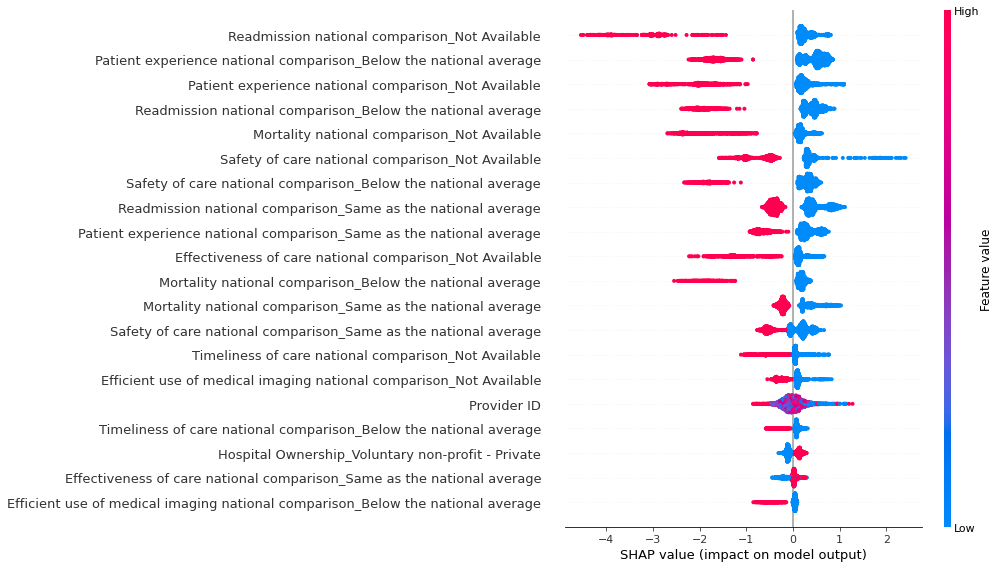

In [39]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

# Bar plot for Pairwise model

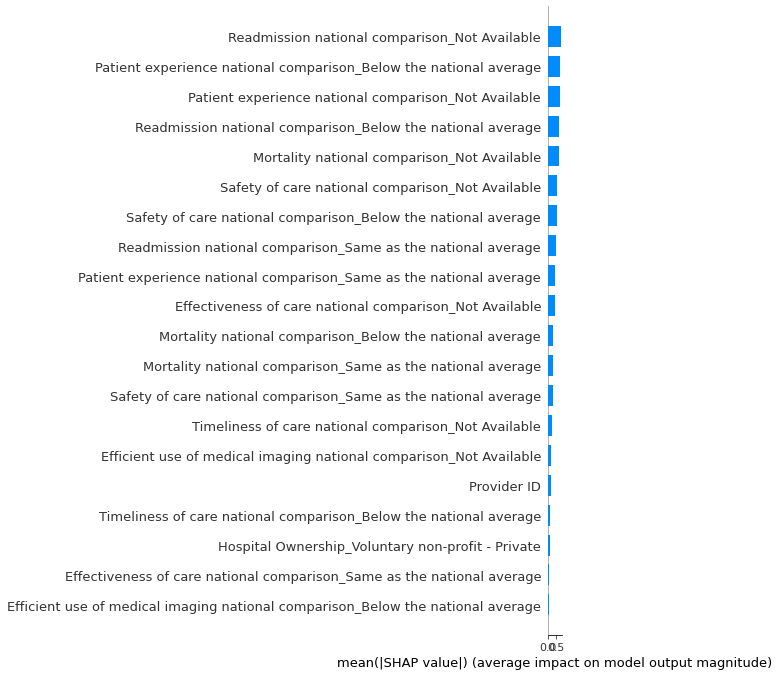

In [40]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

# Preparing fresh train-test data for Listwise model

In [41]:
train_data= data_dummies.iloc[X_train_inds]
X_train = train_data.loc[:, ~train_data.columns.isin(['State','Hospital overall rating'])]
y_train = train_data.loc[:, train_data.columns.isin(['Hospital overall rating'])]

In [42]:
test_data= data_dummies.iloc[X_test_inds]

#We need to keep the id for later predictions
X_test = test_data.loc[:, ~test_data.columns.isin(['Hospital overall rating'])]
y_test = test_data.loc[:, test_data.columns.isin(['Hospital overall rating'])]

In [43]:
groups = train_data.groupby('State').size().to_frame('size')['size'].to_numpy()

In [44]:
X_train = X_train.loc[:,~X_train.columns.duplicated()]

In [45]:
X_test = X_test.loc[:,~X_test.columns.duplicated()]

# Creating and executing study for Listwise model

In [46]:
study_listwise = optuna.create_study(direction='maximize')
study_listwise.optimize(objective_listwise, n_trials=30)
print('Number of finished trials:', len(study_listwise.trials))
print('Best trial:', study_listwise.best_trial.params)

[I 2022-08-28 12:35:40,694] A new study created in memory with name: no-name-3a1b765e-3f53-458f-a425-1f33e14b202b
[I 2022-08-28 12:36:39,002] Trial 0 finished with value: 0.8107399031902814 and parameters: {'learning_rate': 0.08, 'colsample_bytree': 0.4, 'eta': 0.08, 'max_depth': 9, 'n_estimators': 130, 'subsample': 0.8}. Best is trial 0 with value: 0.8107399031902814.
[I 2022-08-28 12:37:35,422] Trial 1 finished with value: 0.7306891857201362 and parameters: {'learning_rate': 0.12, 'colsample_bytree': 0.4, 'eta': 0.08, 'max_depth': 11, 'n_estimators': 140, 'subsample': 0.4}. Best is trial 0 with value: 0.8107399031902814.
[I 2022-08-28 12:38:31,450] Trial 2 finished with value: 0.7063808670400832 and parameters: {'learning_rate': 0.08, 'colsample_bytree': 0.4, 'eta': 0.06, 'max_depth': 7, 'n_estimators': 120, 'subsample': 0.4}. Best is trial 0 with value: 0.8107399031902814.
[I 2022-08-28 12:39:37,219] Trial 3 finished with value: 0.8201257810603131 and parameters: {'learning_rate': 0

Number of finished trials: 30
Best trial: {'learning_rate': 0.16, 'colsample_bytree': 0.7, 'eta': 0.07, 'max_depth': 5, 'n_estimators': 100, 'subsample': 1.0}


# Hyper-parameter Importance for Listwise Model

In [47]:
optuna.visualization.plot_param_importances(study_listwise)

# Training Listwise model using best hyper-parameters

In [48]:
model_listwise = xgb.XGBRanker(
    booster= 'gbtree',
    objective= 'rank:ndcg',
    random_state= 42,
    learning_rate= study_listwise.best_trial.params['learning_rate'],
    colsample_bytree= study_listwise.best_trial.params['colsample_bytree'],
    eta= study_listwise.best_trial.params['eta'],
    max_depth= study_listwise.best_trial.params['max_depth'],
    n_estimators= study_listwise.best_trial.params['n_estimators'],
    subsample= study_listwise.best_trial.params['subsample'],
    n_jobs= -1
)

model_listwise.fit(X_train, y_train, group=groups, verbose=True)

XGBRanker(base_score=0.5, booster='gbtree', colsample_bylevel=1,
          colsample_bynode=1, colsample_bytree=0.7, enable_categorical=False,
          eta=0.07, gamma=0, gpu_id=-1, importance_type=None,
          interaction_constraints='', learning_rate=0.16, max_delta_step=0,
          max_depth=5, min_child_weight=1, missing=nan,
          monotone_constraints='()', n_estimators=100, n_jobs=-1,
          num_parallel_tree=1, objective='rank:ndcg', predictor='auto',
          random_state=42, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
          subsample=1.0, tree_method='exact', validate_parameters=1,
          verbosity=None)

# Generating and visualizing listwise predictions

In [49]:
predictions_listwise = (X_test.groupby('State')
           .apply(lambda x: predict(model_listwise, x)))

In [50]:
predictions_listwise

State
AL    [0.89532435, 1.4129694, 0.36069065, -0.1438417...
FL    [-0.188962, 2.1345649, 0.66666734, 0.19823949,...
GU                                         [-0.7782815]
HI    [2.413393, 0.39237198, 0.23122363, 1.9308842, ...
ID    [1.8679858, 2.4198031, 3.4576824, 1.4765515, 2...
IN    [2.9926538, 0.09294803, -0.24959514, 2.581489,...
KS    [2.1785278, 0.29175714, 1.3852164, 2.5271225, ...
LA    [1.2586664, 2.590443, 0.65336, 0.5320308, 1.36...
MD    [-2.9530268, -2.9530268, -2.9530268, -2.953026...
MP                                         [-1.4553663]
MT    [2.3172677, 2.7879407, 1.6202314, 2.2683196, 2...
NE    [2.3172677, 2.162896, 0.88449824, 2.2442894, 0...
NH    [1.6363776, 2.129904, 1.0624062, 0.4992603, 1....
NJ    [-0.35679883, -0.49384373, 0.05505622, 2.26480...
NM    [-0.07642018, 1.5476844, 0.6391921, 0.78692037...
NY    [0.0071809953, 0.07525102, 1.500536, 0.0752510...
OR    [2.1372385, 1.2735215, 2.8743246, 2.3280811, 2...
PA    [0.28344792, 0.3916784, 0.66942436, 

# Merging test dataset with predicted values

In [51]:
X_test = X_test.reset_index()
test_data = test_data.reset_index()
test_data = test_data.loc[:,~test_data.columns.duplicated()]
X_test_listwise = merge_df(test_data,predictions_listwise)

In [52]:
X_test_listwise

index  Provider ID State  Hospital overall rating  \
0         0        10001    AL                        3   
1         1        10005    AL                        3   
2         2        10006    AL                        2   
3         3        10007    AL                        2   
4         4        10008    AL                        3   
...     ...          ...   ...                      ...   
1646   4738       531314    WY                        0   
1647   4739       531315    WY                        0   
1648   4740       531316    WY                        0   
1649   4809       650001    GU                        3   
1650   4811       660001    MP                        0   

      Hospital Name_ABBEVILLE GENERAL HOSPITAL  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
1646                                         0   
1647                                         0   
1648                                         0   
1649                                         0   
1650                                         0   

      Hospital Name_ABBOTT NORTHWESTERN HOSPITAL  \
0                                              0   
1                                              0   
2                                              0   
3                                              0   
4                                              0   
...                                          ...   
1646                                           0   
1647                                           0   
1648                                           0   
1649                                           0   
1650                                           0   

      Hospital Name_ABILENE REGIONAL MEDICAL CENTER  \
0                                                 0   
1                                                 0   
2                                                 0   
3                                                 0   
4                                                 0   
...                                             ...   
1646                                              0   
1647                                              0   
1648                                              0   
1649                                              0   
1650                                              0   

      Hospital Name_ABINGTON MEMORIAL HOSPITAL  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
1646                                         0   
1647                                         0   
1648                                         0   
1649                                         0   
1650                                         0   

      Hospital Name_ABRAHAM LINCOLN MEMORIAL HOSPITAL  \
0                                                   0   
1                                                   0   
2                                                   0   
3                                                   0   
4                                                   0   
...                                               ...   
1646                                                0   
1647                                                0   
1648                                                0   
1649                                                0   
1650                                                0   

      Hospital Name_ABRAZO ARROWHEAD CAMPUS  ...  \
0                                         0  ...   
1                   

# Preparing 'ranx' dictionaries for Listwise model

In [53]:
Qrels_df = X_test_listwise[['Provider ID','State','Hospital overall rating']]
run_df_listwise = X_test_listwise[['Provider ID','State','pred_rank']]

Qrels_df = Qrels_df.groupby('State').apply(lambda x: x.sort_values('Hospital overall rating',ascending=False))
run_df_listwise = run_df_listwise.groupby('State').apply(lambda x: x.sort_values('pred_rank',ascending=False))

In [54]:
qrels_dict = dict()
run_dict_listwise = dict()

qrels = Qrels(generate_qrels(Qrels_df,qrels_dict))
run_listwise = Run(generate_run(run_df_listwise,run_dict_listwise), name="Listwise Model")

In [55]:
explainer = shap.TreeExplainer(model_listwise)
shap_values = explainer.shap_values(X_train)

# Force plot for 1st and 100th record for Listwise model

In [56]:
i = 1
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

In [57]:
i = 100
shap.force_plot(explainer.expected_value, shap_values[i], features=X_train.iloc[i], feature_names=X_train.columns)

# Summary plot for Listwise model

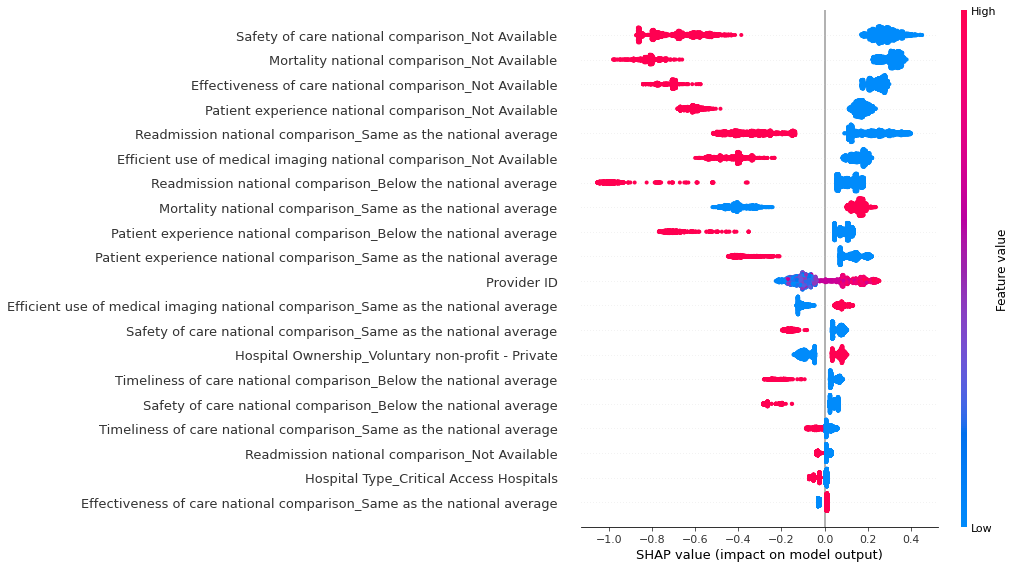

In [58]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns)

# Bar plot for Listwise model

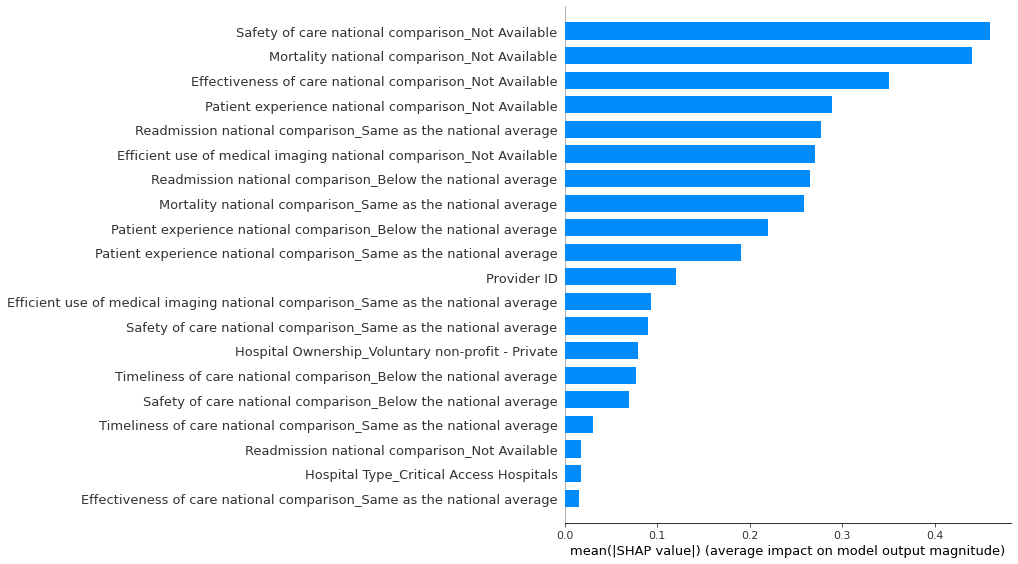

In [59]:
shap.summary_plot(shap_values, features=X_train, feature_names=X_train.columns, plot_type='bar')

# Metric evaluation and comparison for Pairwise and Listwise model

In [60]:
report = compare(
    qrels,
    runs=[run_pairwise, run_listwise],
    metrics=["ndcg@5", "precision@5", "recall@5", "hits", "hit_rate", "map@5"],
    max_p=0.01,  # P-value threshold
    rounding_digits=3,
    show_percentages=True,
)

report

#    Model           NDCG@5      P@5    Recall@5    Hits    Hit_Rate    MAP@5
---  --------------  --------  -----  ----------  ------  ----------  -------
a    Pairwise Model  87.2ᵇ      87.8        17.4  5373.9        91.3     17.4
b    Listwise Model  82.7       87.8        17.4  5373.9        91.3     17.4

# From the above metrics which are very similar except for NDCG@5, we can conclude that the Pairwise model is performing better for our use case